In [1131]:
import numpy as np
from astropy.table import Table
import astropy.io.fits as pyfits
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
import corner
import imageio as iio
from datetime import date
today = date.today()

In [1132]:
date = '230206'
setup = 'allstar'
# setup = 'allspec'

In [1133]:
data,header = pyfits.getdata('../spectrum_post_processing/galah_dr4_'+setup+'_not_validated.fits', header=True)

accuracy_applied = False
applied_fe_h_shift = False
applied_zeropoint_shift = False

# Zeropoints

In [1134]:
zeropoint_solar = dict()
zeropoint_solar['teff'] = 5772.
zeropoint_solar['logg'] = 4.438
zeropoint_solar['fe_h'] = 0.00
zeropoint_solar['vmic'] = 1.06
zeropoint_solar['vsini'] = 4.50 # np.sqrt(1.6**2 + 4.2**2)

# Solar Abundances
marcs2014_a_x_sun = dict()
elements = [
 "H",  "He",  "Li",  "Be",   "B",   "C",   "N",   "O",   "F",  "Ne",
"Na",  "Mg",  "Al",  "Si",   "P",   "S",  "Cl",  "Ar",   "K",  "Ca",
"Sc",  "Ti",   "V",  "Cr",  "Mn",  "Fe",  "Co",  "Ni",  "Cu",  "Zn",
"Ga",  "Ge",  "As",  "Se",  "Br",  "Kr",  "Rb",  "Sr",   "Y",  "Zr",
"Nb",  "Mo",  "Tc",  "Ru",  "Rh",  "Pd",  "Ag",  "Cd",  "In",  "Sn",
"Sb",  "Te",   "I",  "Xe",  "Cs",  "Ba",  "La",  "Ce",  "Pr",  "Nd",
"Pm",  "Sm",  "Eu",  "Gd",  "Tb",  "Dy",  "Ho",  "Er",  "Tm",  "Yb",
"Lu",  "Hf",  "Ta",   "W",  "Re",  "Os",  "Ir",  "Pt",  "Au",  "Hg",
"Tl",  "Pb",  "Bi",  "Po",  "At",  "Rn",  "Fr",  "Ra",  "Ac",  "Th",
"Pa",   "U",  "Np",  "Pu",  "Am",  "Cm",  "Bk",  "Cs",  "Es"
]
a_x = [
12.00, 10.93,  1.05,  1.38,  2.70,  8.39,  7.78,  8.66,  4.56,  7.84,
 6.17,  7.53,  6.37,  7.51,  5.36,  7.14,  5.50,  6.18,  5.08,  6.31,
 3.17,  4.90,  4.00,  5.64,  5.39,  7.45,  4.92,  6.23,  4.21,  4.60,
 2.88,  3.58,  2.29,  3.33,  2.56,  3.25,  2.60,  2.92,  2.21,  2.58,
 1.42,  1.92, -8.00,  1.84,  1.12,  1.66,  0.94,  1.77,  1.60,  2.00,
 1.00,  2.19,  1.51,  2.24,  1.07,  2.17,  1.13,  1.70,  0.58,  1.45,
-8.00,  1.00,  0.52,  1.11,  0.28,  1.14,  0.51,  0.93,  0.00,  1.08,
 0.06,  0.88, -0.17,  1.11,  0.23,  1.25,  1.38,  1.64,  1.01,  1.13,
 0.90,  2.00,  0.65, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00,  0.06,
-8.00, -0.52, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00]
for (element, a_x) in zip(elements, a_x):
    zeropoint_solar['a_'+element.lower()] = a_x

# ALLSPEC

labels = ['teff','logg','fe_h','a_fe','vmic','vsini','a_li','a_c','a_n','a_o','a_na','a_mg','a_al','a_si','a_k','a_ca','a_sc','a_ti','a_v','a_cr','a_mn','a_co','a_ni','a_cu','a_zn','a_rb','a_sr','a_y','a_zr','a_mo','a_ru','a_ba','a_la','a_ce','a_nd','a_sm','a_eu']

vesta_allspec = Table.read('../analysis_products/210115/210115002201239/210115002201239_single_fit_results.fits')

zeropoint_allspec = dict()
for label in labels:
    if label[:2] == 'a_':
        if label == 'a_fe':
            zeropoint_allspec[label] = vesta_allspec['fe_h'][0] + zeropoint_solar[label]
        else:
            zeropoint_allspec[label] = vesta_allspec[label[2:]+'_fe'][0] + vesta_allspec['fe_h'][0] + zeropoint_solar[label]
    else:
        zeropoint_allspec[label] = vesta_allspec[label][0]

# ALLSTAR

vesta_allstar = Table.read('../analysis_products/210115/210115002201239/210115002201239_plxcom_fit_results.fits')

zeropoint_allstar = dict()
for label in labels:
    if label[:2] == 'a_':
        if label == 'a_fe':
            zeropoint_allstar[label] = vesta_allstar['fe_h'][0] + zeropoint_solar[label]
        else:
            zeropoint_allstar[label] = vesta_allstar[label[2:]+'_fe'][0] + vesta_allstar['fe_h'][0] + zeropoint_solar[label]
    else:
        zeropoint_allstar[label] = vesta_allstar[label][0]

# MASTER ZEROPOINT TABLE

zeropoints = Table()

zeropoints['label'] = labels
zeropoints['solar_G07'] = np.array([zeropoint_solar[label] for label in labels],dtype=np.float32)

# THESE ARE THE SHIFT WE WILL APPLY
zeropoints['zeropt_allspec'] = np.array([
    5772 , # Teff
    4.438, # logg
    0.10 , # [Fe/H]
    7.55 , # A(Fe)
    1.06 , # vmic
    4.50 , # vsini
    zeropoint_solar['a_li']  + 0.0,
    zeropoint_solar['a_c']   + 0.0,
    zeropoint_solar['a_n']   + 0.0,
    zeropoint_solar['a_o']   + 0.0,
    zeropoint_solar['a_na']  + 0.0,
    zeropoint_solar['a_mg']  + 0.0,
    zeropoint_solar['a_al']  + 0.0,
    zeropoint_solar['a_si']  + 0.0,
    zeropoint_solar['a_k']   + 0.0,
    zeropoint_solar['a_ca']  + 0.0,
    zeropoint_solar['a_sc']  + 0.0,
    zeropoint_solar['a_ti']  + 0.0,
    zeropoint_solar['a_v']   + 0.0,
    zeropoint_solar['a_cr']  + 0.0,
    zeropoint_solar['a_mn']  + 0.0,
    zeropoint_solar['a_co']  + 0.0,
    zeropoint_solar['a_ni']  + 0.0,
    zeropoint_solar['a_cu']  + 0.0,
    zeropoint_solar['a_zn']  + 0.0,
    zeropoint_solar['a_rb']  + 0.0,
    zeropoint_solar['a_sr']  + 0.0,
    zeropoint_solar['a_y']   + 0.0,
    zeropoint_solar['a_zr']  + 0.0,
    zeropoint_solar['a_mo']  + 0.0,
    zeropoint_solar['a_ru']  + 0.0,
    zeropoint_solar['a_ba']  + 0.0,
    zeropoint_solar['a_la']  + 0.0,
    zeropoint_solar['a_ce']  + 0.0,
    zeropoint_solar['a_nd']  + 0.0,
    zeropoint_solar['a_sm']  + 0.0,
    zeropoint_solar['a_eu']  + 0.0,
],dtype=np.float32)
    
zeropoints['zeropt_allstar'] = np.array([
    5772 , # Teff
    4.438, # logg
    0.049, # [Fe/H]
    7.45 +0.049, # A(Fe)
    1.06 , # vmic
    4.50 , # vsini
    zeropoint_solar['a_li']  + 0.000, # keep
    zeropoint_solar['a_c']   + 0.023, # adjust to VESTA
    zeropoint_solar['a_n']   - 0.075, # adjust to APOGEE
    zeropoint_solar['a_o']   - 0.001, # adjust to Solar Twins
    zeropoint_solar['a_na']  - 0.171, # adjust to Solar Twins
    zeropoint_solar['a_mg']  - 0.085, # adjust to APOGEE
    zeropoint_solar['a_al']  - 0.185, # adjust to Solar radius
    zeropoint_solar['a_si']  - 0.024, # adjust to VESTA
    zeropoint_solar['a_k']   - 0.051, # adjust to VESTA
    zeropoint_solar['a_ca']  - 0.041, # adjust to Solar radius
    zeropoint_solar['a_sc']  + 0.031, # adjust to VESTA
    zeropoint_solar['a_ti']  + 0.022, # adjust to limit
    zeropoint_solar['a_v']   + 0.124, # adjust to VESTA
    zeropoint_solar['a_cr']  + 0.000, # keep
    zeropoint_solar['a_mn']  - 0.101, # adjust to Solar Twins
    zeropoint_solar['a_co']  + 0.130, # adjust to VESTA
    zeropoint_solar['a_ni']  - 0.002, # adjust to Solar Twins
    zeropoint_solar['a_cu']  + 0.208, # adjust to Solar radius
    zeropoint_solar['a_zn']  + 0.051, # adjust to VESTA
    zeropoint_solar['a_rb']  + 0.000, # keep
    zeropoint_solar['a_sr']  + 0.000, # keep
    zeropoint_solar['a_y']   + 0.054, # adjust to VESTA
    zeropoint_solar['a_zr']  + 0.000, # keep
    zeropoint_solar['a_mo']  + 0.000, # keep
    zeropoint_solar['a_ru']  + 0.000, # keep
    zeropoint_solar['a_ba']  - 0.022, # adjust to Solar Twins
    zeropoint_solar['a_la']  + 0.000, # keep
    zeropoint_solar['a_ce']  + 0.070, # adjust to APOGEE
    zeropoint_solar['a_nd']  - 0.022, # adjust to Solar Twins
    zeropoint_solar['a_sm']  + 0.000, # keep
    zeropoint_solar['a_eu']  + 0.000, # keep
],dtype=np.float32)

# THESE ARE THE SHIFT WE WILL APPLY
zeropoints['shift_allspec'] = np.array(np.round(zeropoints['solar_G07'] - zeropoints['zeropt_allspec'],3),dtype=np.float32)
zeropoints['shift_allstar'] = np.array(np.round(zeropoints['solar_G07'] - zeropoints['zeropt_allstar'],3),dtype=np.float32)

# INFORMATION 1: VESTA
zeropoints['vesta_allspec'] = np.array([np.round(zeropoint_allspec[label],3) for label in labels],dtype=np.float32)
zeropoints['d_vesta_allspec'] = np.array(np.round(zeropoints['zeropt_allspec'] - [zeropoint_allspec[label] for label in labels],3),dtype=np.float32)
zeropoints['vesta_allstar'] = np.array([np.round(zeropoint_allstar[label],3) for label in labels],dtype=np.float32)
zeropoints['d_vesta_allstar'] = np.array(np.round(zeropoints['zeropt_allstar'] - [zeropoint_allstar[label] for label in labels],3),dtype=np.float32)

In [1135]:
zeropoints

label,solar_G07,zeropt_allspec,zeropt_allstar,shift_allspec,shift_allstar,vesta_allspec,d_vesta_allspec,vesta_allstar,d_vesta_allstar
str5,float32,float32,float32,float32,float32,float32,float32,float32,float32
teff,5772.0,5772.0,5772.0,0.0,0.0,5750.196,21.805,5752.261,19.739
logg,4.438,4.438,4.438,0.0,0.0,4.326,0.112,4.429,0.009
fe_h,0.0,0.1,0.049,-0.1,-0.049,-0.016,0.116,-0.019,0.068
a_fe,7.45,7.55,7.499,-0.1,-0.049,7.434,0.116,7.431,0.068
vmic,1.06,1.06,1.06,0.0,0.0,0.993,0.067,1.0,0.06
vsini,4.5,4.5,4.5,0.0,0.0,5.628,-1.128,5.552,-1.052
a_li,1.05,1.05,1.05,0.0,0.0,1.105,-0.055,1.108,-0.058
a_c,8.39,8.39,8.413,0.0,-0.023,8.376,0.014,8.348,0.065
a_n,7.78,7.78,7.705,0.0,0.075,8.36,-0.58,8.368,-0.663


In [1136]:
if not applied_fe_h_shift:

    finite_fe_h = np.isfinite(data['fe_h'])
    fe_h_adjust = np.array(-0.1*data['fe_h'][finite_fe_h]).clip(0,0.1)
    data['fe_h'][finite_fe_h] += fe_h_adjust
    
    applied_fe_h_shift = True

In [1137]:
# Apply zeropoint shifts
if not applied_zeropoint_shift:
    for label_index, label in enumerate(zeropoints['label']):
        if label[:2] == 'a_':
            if label != 'a_fe':
                print('Shifting '+label[2:]+'_fe by '+str(zeropoints['shift_'+setup][label_index]))
                data[label[2:]+'_fe'] -= zeropoints['shift_'+setup][label_index]
#         elif label == 'vrad':
#             print('Shifting '+label+' by '+str(zeropoints['shift_'+setup][label_index]))
#             data['rv_comp_1'] -=  zeropoints['shift_'+setup][label_index]
#             data['rv_comp_2'] -=  zeropoints['shift_'+setup][label_index]
        else:
            print('Shifting '+label+'_fe by '+str(zeropoints['shift_'+setup][label_index]))
            data[label] -=  zeropoints['shift_'+setup][label_index]

    applied_zeropoint_shift = True
else:
    print('Already applied zeropoint shift')

Shifting teff_fe by 0.0
Shifting logg_fe by 0.0
Shifting fe_h_fe by -0.049
Shifting vmic_fe by 0.0
Shifting vsini_fe by 0.0
Shifting li_fe by 0.0
Shifting c_fe by -0.023
Shifting n_fe by 0.075
Shifting o_fe by 0.001
Shifting na_fe by 0.171
Shifting mg_fe by 0.085
Shifting al_fe by 0.185
Shifting si_fe by 0.024
Shifting k_fe by 0.051
Shifting ca_fe by 0.041
Shifting sc_fe by -0.031
Shifting ti_fe by -0.022
Shifting v_fe by -0.124
Shifting cr_fe by 0.0
Shifting mn_fe by 0.101
Shifting co_fe by -0.13
Shifting ni_fe by 0.002
Shifting cu_fe by -0.208
Shifting zn_fe by -0.051
Shifting rb_fe by 0.0
Shifting sr_fe by 0.0
Shifting y_fe by -0.054
Shifting zr_fe by 0.0
Shifting mo_fe by 0.0
Shifting ru_fe by 0.0
Shifting ba_fe by 0.022
Shifting la_fe by 0.0
Shifting ce_fe by -0.07
Shifting nd_fe by 0.022
Shifting sm_fe by 0.0
Shifting eu_fe by 0.0


# Increase Uncertainties

## Precision

In [1138]:
# # First make a copy of the raw covariance uncertainties
# data['cov_teff'] = data['e_teff']

# # Then increase the precision depending on covariance and repeat uncertainties
# data['e_teff'] = data['e_teff']

## Accuracy

In [1139]:
accuracy = Table()
accuracy['teff'] = [np.round(93. / np.sqrt(2),0)]
accuracy['logg'] = [np.round(0.059 / np.sqrt(2),3)]
accuracy['fe_h'] = [np.round(0.072 / np.sqrt(2),3)]
accuracy['vmic'] = [np.round(0.40 / np.sqrt(2),2)]
accuracy['vsini'] = [np.round(2.0 / np.sqrt(2),1)]
accuracy['vrad'] = [np.round(0.15,2)]
print(accuracy)

if (setup == 'allstar'):
    if accuracy_applied:
        print('Accuracy already taken into account')
    else:
        print('Adjusting uncertainties for accuracy')

        finite_label = np.isfinite(data['e_teff'])
        data['e_teff'][finite_label] = np.sqrt(data['e_teff'][finite_label]**2 + accuracy['teff'][0]**2) # GBS

        finite_label = np.isfinite(data['e_teff'])
        data['e_logg'][finite_label] = np.sqrt(data['e_logg'][finite_label]**2 + accuracy['teff'][0]**2) # seismic (GBS smaller)

        finite_label = np.isfinite(data['e_teff'])
        data['e_fe_h'][finite_label] = np.sqrt(data['e_fe_h'][finite_label]**2 + accuracy['fe_h'][0]**2) # GBS

        finite_label = np.isfinite(data['e_vmic'])
        data['e_vmic'][finite_label] = np.sqrt(data['e_vmic'][finite_label]**2 + accuracy['vmic'][0]**2) # APOGEE

        finite_label = np.isfinite(data['e_vsini'])
        data['e_vsini'][finite_label] = np.sqrt(data['e_vsini'][finite_label]**2 + accuracy['vsini'][0]**2) # APOGEE
        
        finite_label = np.isfinite(data['e_rv_comp_1'])
        data['e_rv_comp_1'][finite_label] = np.sqrt(data['e_rv_comp_1'][finite_label]**2 + accuracy['vrad'][0]**2) # Gaia DR3
        finite_label = np.isfinite(data['e_rv_comp_2'])
        data['e_rv_comp_2'][finite_label] = np.sqrt(data['e_rv_comp_2'][finite_label]**2 + accuracy['vrad'][0]**2) # Gaia DR3
        
        accuracy.write('galah_dr4_allstar_accuracy.fits',overwrite=True)

        accuracy_applied = True

teff  logg  fe_h vmic vsini vrad
---- ----- ----- ---- ----- ----
66.0 0.042 0.051 0.28   1.4 0.15
Adjusting uncertainties for accuracy


In [1102]:
description = dict()
# Major identifiers
description['sobject_id'] = 'GALAH identifier'
description['tmass_id'] = '2MASS identifier'
description['gaiadr3_source_id'] = 'Gaia DR3 source_id'
description['ra'] = 'propagated from Gaia DR3'
description['dec'] = 'propagated from Gaia DR3'
description['mjd'] = 'Modified Julian Date'
description['setup'] = 'Analysis setup: single/binary/coadds'
description['best_spec4star'] = 'Best spectrum for given star (identifiable via 2MASS ID)'
description['px_used_perc'] = 'Percentage of spectrum used for spectroscopic fit'
description['comp_time'] = 'Computation time spent on spectrum'
description['survey_name'] = 'HERMES-2dF Survey/Program/Pointing (other if not available)'
description['field_id'] = 'GALAH Field ID (-1 if not available)'

# Main spectroscopic results
description['flag_sp'] = 'Major spectroscopic quality bitmask flag'
description['flag_sp_fit'] = 'Major spectroscopic fitting quality bitmask flag'
description['flag_red'] = 'Quality bitmask flag of reduction pipeline'
description['fit_global_rv'] = 'Are spectra coadded (without RV shifts) and then a global RV fitted?'
description['chi2_sp'] = 'Chi2 value of spectroscopic fitting'
description['model_name'] = 'Neural network model used for creating synthetic spectra'
description['closest_model'] = 'Neural network model closest for Teff/logg/[Fe/H] combination'
description['teff'] = 'Spectroscopic effective temperature (used for fitting)'
description['e_teff'] = 'Uncertainty teff'
description['logg'] = 'Surface gravity adjusted via parallax information'
description['e_logg'] = 'Uncertainty logg_plx'
description['logg_spec'] = 'Spectroscopic surface gravity (used for fitting)'
description['e_logg_spec'] = 'Uncertainty logg_spec'
description['fe_h'] = 'Abundance of Fe and all other elements not fitted in GALAH (Fe: 1D-NLTE)'
description['e_fe_h'] = 'Uncertainty fe_h'
description['flag_fe_h'] = 'Quality flag fe_h'
description['vmic'] = 'Microturbulence velocity (fitted)'
description['e_vmic'] = 'Uncertainty vmic'
description['vsini'] = 'Broadening velocity (fitted sme.vsini with sme.vmac=0)'
description['e_vsini'] = 'Uncertainty of vsini'

description['flux_contr'] = 'Flux contribution of main source'
description['e_flux_contr'] = 'Uncertainty flux_contr'
description['rv_comp_nr'] = 'Number of peaks in RV cross-correlation function (CCF)'
description['rv_comp_1'] = 'Radial velocity of primary source'
description['e_rv_comp_1'] = 'Uncertainty of rv_comp_1'
description['rv_comp_1_h'] = 'Height of rv_comp_1 in CCF'
description['rv_comp_1_p'] = 'Prominence of rv_comp_1 in CCF'
description['rv_comp_2'] = 'Radial velocity of potential secondary source'
description['e_rv_comp_2'] = 'Uncertainty of rv_comp_1'
description['rv_comp_2_h'] = 'Height of rv_comp_1 in CCF'
description['rv_comp_2_p'] = 'Prominence of rv_comp_1 in CCF'
description['rv_gaia_dr3'] = 'Radial velocity in Gaia DR3'
description['e_rv_gaia_dr3'] = 'Uncertainty of rv_gaia_dr3'
description['teff_comp_2'] = 'Spectroscopic effective temperature of potential secondary source'
description['e_teff_comp_2'] = 'Uncertainty of teff_comp_2'
description['logg_comp_2'] = 'Spectroscopic surface gravity of potential secondary source'
description['e_logg_comp_2'] = 'Uncertainty of logg_comp_2'
description['fe_h_comp_2'] = 'Abundance of Fe of potential secondary source'
description['e_fe_h_comp_2'] = 'Uncertainty of fe_h_comp_2'
description['flag_fe_h_comp_2'] = 'Quality flag fe_h_comp_2'
description['vmic_comp_2'] = 'Microturbulence velocity of potential secondary source'
description['e_vmic_comp_2'] = 'Uncertainty of vmic_comp_2'
description['vsini_comp_2'] = 'Broadening velocity of potential secondary source'
description['e_vsini_comp_2'] = 'Uncertainty of vsini_comp_2'

# Elemental abundances
for each in [
    'Li',
    'C',
    'N',
    'O',
    'Na',
    'Mg',
    'Al',
    'Si',
    'K',
    'Ca',
    'Sc',
    'Ti',
    'V',
    'Cr',
    'Mn',
    'Co',
    'Ni',
    'Cu',
    'Zn',
    'Rb',
    'Sr',
    'Y',
    'Zr',
    'Mo',
    'Ru',
    'Ba',
    'La',
    'Ce',
    'Nd',
    'Sm',
    'Eu',
]:
    description[each.lower()+'_fe'] = 'Elemental abundance for ['+each+'/Fe]'
    description['e_'+each.lower()+'_fe'] = 'Uncertainty '+each+'_fe'
    description['flag_'+each.lower()+'_fe'] = 'Quality bitmask flag of '+each+'_fe'

# Reduction information
description['v_bary_eff'] = 'Barycentric velocity applied to reduced spectra'
description['red_rv_ccd'] = 'Reduction pipeline best radial velocity for each CCD'
description['red_e_rv_ccd'] = 'Reduction pipeline uncertainty of red_rv_ccd'
description['red_rv_com'] = 'Reduction pipeline combined best radial velocity'
description['red_e_rv_com'] = 'Reduction pipeline uncertainty of red_rv_com'
description['red_teff'] = 'Reduction pipeline best teff'
description['red_logg'] = 'Reduction pipeline best logg'
description['red_fe_h'] = 'Reduction pipeline best fe_h'
description['red_alpha_fe'] = 'Reduction pipeline best alpha_fe'
description['red_vmic'] = 'Reduction pipeline best vmic'
description['red_vbroad'] = 'Reduction pipeline best vbroad'
description['red_flag'] = 'Reduction pipeline quality bitmask flag'

# Additional parameters of post-processing for binarity, emission, interstellar residuals etc.
description['sb2_rv_16'] = '16th perc. radial velocity of fit to syn-obs residuals'
description['sb2_rv_50'] = '50th perc. radial velocity of fit to syn-obs residuals'
description['sb2_rv_84'] = '84th perc. radial velocity of fit to syn-obs residuals'
description['ew_h_beta'] = 'Equivalent Width of observed Hbeta core'
description['ew_h_alpha'] = 'Equivalent Width of observed Halpha core'
description['res_h_beta'] = 'Residual Equivalent Width of syn-obs residuals at Hbeta core'
description['res_h_alpha'] = 'Residual Equivalent Width of syn-obs residuals at Halpha core'
description['ew_k_is'] = 'Equivalent Width of fit for K7699 Interstellar Line'
description['sigma_k_is'] = 'Sigma auf Gaussian fit for K7699 Interstellar Line'
description['rv_k_is'] = 'Radial velocity of fit to syn-obs residuals around K7699 line'
description['ew_dib5780'] = 'Equivalent Width of fit for 5780 Diffiuse Interstellar Band'
description['sigma_dib5780'] = 'Sigma auf Gaussian fit for 5780 DIB'
description['rv_dib5780'] = 'Radial velocity of fit to syn-obs residuals around 5780 DIB'
description['ew_dib5797'] = 'Equivalent Width of fit for 5797 Diffiuse Interstellar Band'
description['sigma_dib5797'] = 'Sigma auf Gaussian fit for 5797 DIB'
description['rv_dib5797'] = 'Radial velocity of fit to syn-obs residuals around 5797 DIB'
description['ew_dib6613'] = 'Equivalent Width of fit for 6613 Diffiuse Interstellar Band'
description['sigma_dib6613'] = 'Sigma auf Gaussian fit for 6613 DIB'
description['rv_dib6613'] = 'Radial velocity of fit to syn-obs residuals around 6613 DIB'

description['opt_loop'] = 'Nr of optimisation loops used for fitting'
description['phot_g_mean_mag'] = 'Mean Gaia DR3 G-band apparent magnitude'
description['phot_bp_mean_mag'] = 'Mean Gaia DR3 BP-band apparent magnitude'
description['bp_rp'] = 'Color of BP-RP bands'
description['j_m'] = '2MASS J-band magnitude'
description['j_msigcom'] = 'Uncertainty of j_m'
description['h_m'] = '2MASS H-band magnitude'
description['h_msigcom'] = 'Uncertainty of h_m'
description['ks_m'] = '2MASS Ks-band magnitude'
description['ks_msigcom'] = 'Uncertainty of ks_m'
description['W2mag'] = 'AllWISE W2-band magnitude'
description['e_W2mag'] = 'uncertainty of W2mag'
description['ebv'] = 'Extinction E(B-V)'
description['parallax'] = 'Astrometric parallax used for GALAH DR4'
description['e_parallax'] = 'Uncertainty of astrometric parallax used for GALAH DR4'
description['parallax_gaia_edr3'] = 'Parallax reported with corrections by Gaia EDR3'
description['e_parallax_gaia_edr3'] = 'Uncertainty of parallax reported with corrections by Gaia EDR3'
description['ruwe_gaia_dr3'] = 'RUWE reported by Gaia DR3'
description['r_med'] = 'Median Distance used for calculating logg(plx)'
description['r_lo'] = 'Lower Limit Distance used for calculating logg(plx)'
description['r_hi'] = 'Higher Limit Distance used for calculating logg(plx)'
description['a_ks'] = 'Attenuation in Ks-band A(Ks) used for calculating logg(plx)'
description['mass'] = 'Mass used for calculating logg(plx)'
description['age'] = 'Age estimated when calculating mass'
description['bc_ks'] = 'Bolometric Correction of Ks, BC(Ks), used for calculating logg(plx)'
description['lbol'] = 'Bolometric Luminosity used for calculating logg(plx)'

for ccd in [1,2,3,4]:
    description['snr_px_ccd'+str(ccd)] = 'Average signal-to-noise ratio (per pixel) of CCD'+str(ccd)

In [1103]:
units = dict()
for each in description.keys():
    units[each] = ''
    if each in ['sobject_id','tmass_id','gaiadr3_source_id','setup','best_spec4star',
                'flag_sp','flag_sp_fit','flag_red','chi2_sp','model_name','closest_model',
                'flag_fe_h','flag_fe_h_comp_2','rv_comp_nr',
                'red_flag','flux_contr','e_flux_contr','rv_comp_1_h','rv_comp_2_h','rv_comp_1_p','rv_comp_2_p',
                'snr','survey_name','field_id','opt_loop','ruwe_gaia_dr3','fit_global_rv'
               ]:
        pass
    elif (each[:2] == 'rv') | (each[:4] == 'e_rv'):
        units[each] = 'km s-1'
    elif (each[:4] == 'teff') | (each[-4:] == 'teff') | (each[:6] == 'e_teff'):
        units[each] = 'K'
    elif (each[:4] == 'logg') | (each[-4:] == 'logg') | (each[:6] == 'e_logg'):
        units[each] = 'log(cm.s**-2)'
    elif (each[:4] == 'fe_h') | (each[-4:] == 'fe_h') | (each[:6] == 'e_fe_h'):
        units[each] = 'dex'
    elif (each[:4] == 'vmic') | (each[-4:] == 'vmic') | (each[:6] == 'e_vmic'):
        units[each] = 'km s-1'
    elif (each[:5] == 'vsini') | (each[-5:] == 'vsini') | (each[:7] == 'e_vsini'):
        units[each] = 'km s-1'
    elif each in ['vmic','e_vmic','vsini','e_vsini',
                  'v_bary_eff',
                  'red_rv_ccd','red_e_rv_ccd','red_rv_com','red_e_rv_com',
                  'red_vmic','red_vbroad',
                  'sb2_rv_16','sb2_rv_50','sb2_rv_84','rv_k_is','rv_dib5780','rv_dib5797','rv_dib6613'
                 ]:
        units[each] = 'km s-1'
    elif each in ['ra','dec']:
        units[each] = 'deg'
    elif each[:6] == 'sigma_':
        units[each] = ''
    elif each[:3] in ['ew_','res']:
        units[each] = 'Angstroem'
    elif each[-3:] == '_fe':
        units[each] = 'dex'
    elif each in ['mjd']:
        units[each] = 'd'
    elif each[:3] == 'snr':
        units[each] = ''
    elif each == 'px_used_perc':
        units[each] = '%'
    elif each == 'comp_time':
        units[each] = 's'
    elif each in ['phot_g_mean_mag','phot_bp_mean_mag','bp_rp','j_m','j_msigcom','h_m','h_msigcom','ks_m','ks_msigcom','W2mag','e_W2mag','ebv','a_ks','bc_ks']:
        units[each] = 'mag'
    elif each in ['parallax','e_parallax','parallax_gaia_edr3','e_parallax_gaia_edr3']:
        units[each] = 'mas'
    elif each in ['r_med','r_lo','r_hi']:
        units[each] = 'pc'
    elif each in ['mass']:
        units[each] = 'solMass'
    elif each in ['age']:
        units[each] = 'Gyr'
    elif each in ['lbol']:
        units[each] = 'solLum'
    else:
        print("'"+each+"',")

In [1104]:
# flag_sp_dictionary = dict()

# flag_sp_dictionary['emission']       = [1,'Emission in Halpha/Hbeta detected']
# flag_sp_dictionary['ccd_missing']    = [2,'Not all 4 CCDs available']

# flag_sp_dictionary['is_sb1']         = [4,'Spectroscopic Binary SB1 (RV changes beyond 2sigma)']
# flag_sp_dictionary['is_sb2']         = [8,'Spectroscopic Binary SB2 (Double line splitting)']
# flag_sp_dictionary['chi2_3sigma']    = [16,'Chi2 unusually low/high by 3 sigma']
# flag_sp_dictionary['vsini_warn']     = [32,'Broadening (vsini) warning']
# flag_sp_dictionary['vmic_warn']      = [64,'Microturbulence (vmic) warning']

# flag_sp_dictionary['sb_triple_warn'] = [128,'Double line splitting detected (SB2)']
# flag_sp_dictionary['teff_warn']      = [256,'Temperature (teff) warning']
# flag_sp_dictionary['logg_warn']      = [512,'Gravity (logg) warning']
# flag_sp_dictionary['fe_h_warn']      = [1024,'[Fe/H] (fe_h) warning']
# flag_sp_dictionary['snr_warn']       = [2048,'Signal-to-noise indicates spectra not reliable']
# flag_sp_dictionary['not_converged']  = [4096,'Not converged within 4 iterations']
# flag_sp_dictionary['no_model']       = [8192,'Extrapolating spectrum model']
# flag_sp_dictionary['no_results']     = [16384,'No spectroscopic analysis results available']

# a_file = open("final_flag_sp_dictionary.pkl", "wb")
# pickle.dump(flag_sp_dictionary,a_file)
# a_file.close()

a_file = open("../spectrum_post_processing/final_flag_sp_dictionary.pkl", "rb")
flag_sp_dictionary = pickle.load(a_file)
a_file.close()

if (flag_sp_dictionary['is_sb1'][0] != 4) | (flag_sp_dictionary['no_results'][0] != 16384):
    raise ValueError('Using inconsistent Flag Sp Dictionary!')

In [1105]:
# Double Check for elements without entry
for keys in data.dtype.names:
    if (keys[:4] == 'flag') & (keys[-2:] in ['fe','_h']):
        no_results = data[keys] == -1
        data[keys][no_results] = 2
        
no_phot_logg_no_logg_warn = np.where(np.isnan(data['logg']) & (data['flag_sp'] & flag_sp_dictionary['logg_warn'][0] == 0))
data['flag_sp'][no_phot_logg_no_logg_warn] += flag_sp_dictionary['logg_warn'][0]

for keys in ['flag_sp_fit']:
    no_results = data[keys] == -1
    data[keys][no_results] = 64
    
    # spectrum['flag_sp'] = np.int32(0)
    # flag_sp_closest_3x3x3_model_not_available = np.int32(1)
    # flag_sp_closest_extra6_model_not_available = np.int32(2)
    # flag_sp_no_successful_convergence_within_maximum_loops = np.int32(4)
    # flag_sp_not_all_ccds_available = np.int32(8)
    # flag_sp_negative_fluxes_in_ccds = np.int32(16)
    # flag_sp_negative_resolution_profile = np.int32(32)
    
for keys in ['flag_fe_h_comp_2']:
    no_results = data[keys] == -1
    data[keys][no_results] = 2

In [1106]:
for key in data.dtype.names:    
    if key[:4] == 'flag':
        
        if np.min(data[key]) < 0:
            raise ValueError(key+' has values below 0')
        
#         flag_d = np.array(data[key],dtype=np.float32)
#         flag_d[flag_d==0] = 0.5
#         flag_d = np.log2(flag_d) + 1
        
#         plt.figure()
#         bins=np.arange(np.min(flag_d),np.max(flag_d)+0.01,1)
#         if len(bins) < 3:
#             bins = 3
#         plt.hist(flag_d,bins=bins)
#         plt.title(key)
#         plt.show()
#         plt.close()

In [1107]:
# Correction of stars with too low [C/Fe]: That seems to happen if [N/Fe] is not estimated well!
problematic_cn = (
    # [C/N] < -1 for non-giants
    (
        (data['c_fe'] - data['n_fe'] < -1) & # [C/N] < -1
        ~((data['logg'] < 3.5) & (data['teff'] < 5500)) # not_giant
    ) |
    # No [N/Fe] for non-giants
    (
        (data['flag_n_fe'] >= 2) & # no [N/Fe]
        ~((data['logg'] < 3.5) & (data['teff'] < 5500)) # not_giant
    ) |
    (
        # not_extended_giants
        ~(
            (data['teff'] < 5750.) &
            (data['logg'] < 4.)
        ) &
        np.isfinite(data['n_fe'])
    )
)
data['flag_c_fe'][problematic_cn] += 32
data['flag_n_fe'][problematic_cn] += 32
print(len(data['flag_c_fe'][problematic_cn]))

358114


In [1108]:
if setup == 'allspec':
    init = Table.read('../spectrum_analysis/galah_dr4_initial_parameters_230101_lite.fits')
    init.sort('sobject_id')
    if len(np.where(init['sobject_id'] == data['sobject_id'])[0]) != len(init['sobject_id']):
        raise ValueError('init sorted by sobject_id != same order/entries as data')
        
    elements_in_ccd = dict()
    elements_in_ccd[3] = ['li','ca','ba']

    for ccd in elements_in_ccd.keys():

        for element in elements_in_ccd[ccd]:

            ccd_issues_and_element_measured = ((
                # cdelt issue
                (init['cdelt_flag'] & 2**(ccd-1) > 0) | # e.g. issue in cdelt of ccd3 = 4, flag 2**(3-1)
                # crval issue
                (init['crval_flag'] & 2**(ccd-1) > 0)
            ) & (data['flag_'+element+'_fe'] & 2**1 == 0))

            data['flag_'+element+'_fe'][ccd_issues_and_element_measured] += 64

In [1109]:
len(data['flag_c_fe'][(data['flag_c_fe']<=1)&(data['flag_n_fe']<=1)])

138353

105017


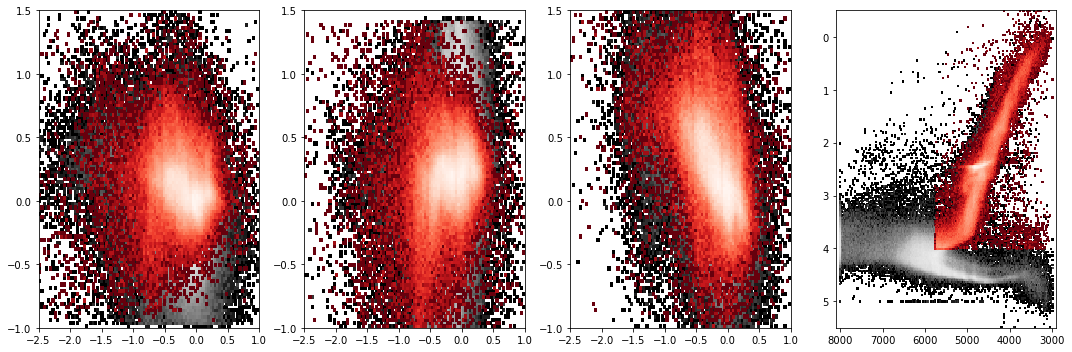

In [1110]:
has_xfe = np.isfinite(data['c_fe']) & np.isfinite(data['logg'])

#subset = data['flag_c_fe'] <= 1# ~problematic_cfe
subset = data['flag_c_fe'] == 0# ~problematic_cfe

print(len(data['teff'][subset]))

f, gs = plt.subplots(1,4,figsize=(15,5))

ax=gs[0]
ax.hist2d(
    data['fe_h'][has_xfe],
    data['c_fe'][has_xfe],
    bins = (np.linspace(-2.5,1.0,100),np.linspace(-1,1.5,100)), cmin=1, cmap='Greys_r', norm=LogNorm()
);
ax.hist2d(
    data['fe_h'][subset],
    data['c_fe'][subset],
    bins = (np.linspace(-2.5,1.0,100),np.linspace(-1,1.5,100)), cmin=1, cmap='Reds_r', norm=LogNorm()
);

ax=gs[1]
ax.hist2d(
    data['fe_h'][has_xfe],
    data['n_fe'][has_xfe],
    bins = (np.linspace(-2.5,1.0,100),np.linspace(-1,1.5,100)), cmin=1, cmap='Greys_r', norm=LogNorm()
);
ax.hist2d(
    data['fe_h'][subset],
    data['n_fe'][subset],
    bins = (np.linspace(-2.5,1.0,100),np.linspace(-1,1.5,100)), cmin=1, cmap='Reds_r', norm=LogNorm()
);

ax=gs[2]
ax.hist2d(
    data['fe_h'][has_xfe],
    data['o_fe'][has_xfe],
    bins = (np.linspace(-2.5,1.0,100),np.linspace(-1,1.5,100)), cmin=1, cmap='Greys_r', norm=LogNorm()
);
ax.hist2d(
    data['fe_h'][subset],
    data['o_fe'][subset],
    bins = (np.linspace(-2.5,1.0,100),np.linspace(-1,1.5,100)), cmin=1, cmap='Reds_r', norm=LogNorm()
);

ax=gs[3]
ax.hist2d(
    data['teff'][has_xfe],
    data['logg'][has_xfe],
    bins = (np.linspace(2900,8100,200),np.linspace(-0.5,5.5,200)), cmin=1, cmap='Greys_r', norm=LogNorm()
);
ax.hist2d(
    data['teff'][subset],
    data['logg'][subset],
    bins = (np.linspace(2900,8100,200),np.linspace(-0.5,5.5,200)), cmin=1, cmap='Reds_r', norm=LogNorm()
);
ax.set_xlim(8100,2900)
ax.set_ylim(5.5,-0.5)
plt.tight_layout()

In [1111]:
if np.nanmax(data['logg']) > 10:
    data['logg'][data['logg'] == np.nanmax(data['logg'])] = np.NaN
data['logg'] = data['logg'].clip(min=-1,max=5.5)

In [1112]:
for each_index, each_key in enumerate(data.dtype.names):
    try:
        header['TTYPE'+str(each_index+1)] = each_key
        header['TUNIT'+str(each_index+1)] = units[each_key]
        header['TCOMM'+str(each_index+1)] = description[each_key]
    except:
        print(each_key)

tbhdu = pyfits.BinTableHDU.from_columns(columns=data,header=header)
tbhdu.writeto('galah_dr4_'+setup+'_'+date+'.fits',overwrite=True)
len(data)

502108

In [1113]:
data = Table.read('galah_dr4_'+setup+'_'+date+'.fits')

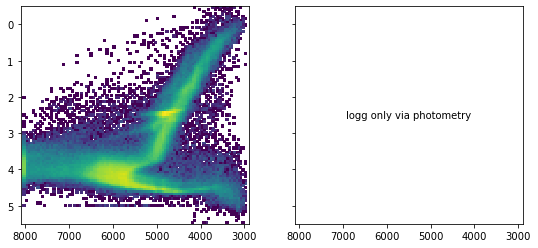

In [1114]:
f, gs = plt.subplots(1,2,figsize=(9,4),sharex=True,sharey=True)
ax = gs[0]
ax.hist2d(
    data['teff'],data['logg'],
    bins = (np.linspace(2900,8100,100),np.linspace(-0.5,5.5,100)),norm=LogNorm()
);
ax = gs[1]
if setup == 'allspec':
    ax.hist2d(
        data['teff'],data['logg_spec'],
        bins = (np.linspace(2900,8100,100),np.linspace(-0.5,5.5,100)),norm=LogNorm()
    );
else:
    ax.text(0.5,0.5,'logg only via photometry',ha='center',va='center',transform=ax.transAxes)
ax.set_xlim(8100,2900)
ax.set_ylim(5.5,-0.5);

In [1115]:
data['date'] = np.array([str(x)[:6] for x in data['sobject_id']])

In [1116]:
fl = Table()
fl['flag_sp_fit'],fl['counts'] = np.unique(data['flag_sp_fit'],return_counts=True)

In [1117]:
flag_sp_dictionary

{'emission': [1, 'Emission in Halpha/Hbeta detected'],
 'ccd_missing': [2, 'Not all 4 CCDs available'],
 'is_sb1': [4, 'Spectroscopic Binary SB1 (RV changes beyond 2sigma)'],
 'is_sb2': [8, 'Spectroscopic Binary SB2 (Double line splitting)'],
 'chi2_3sigma': [16, 'Chi2 unusually low/high by 3 sigma'],
 'vsini_warn': [32, 'Broadening (vsini) warning'],
 'vmic_warn': [64, 'Microturbulence (vmic) warning'],
 'sb_triple_warn': [128, 'Double line splitting detected (SB2)'],
 'teff_warn': [256, 'Temperature (teff) warning'],
 'logg_warn': [512, 'Gravity (logg) warning'],
 'fe_h_warn': [1024, '[Fe/H] (fe_h) warning'],
 'snr_warn': [2048, 'Signal-to-noise indicates spectra not reliable'],
 'not_converged': [4096, 'Not converged within 4 iterations'],
 'no_model': [8192, 'Extrapolating spectrum model'],
 'no_results': [16384, 'No spectroscopic analysis results available']}

In [1118]:
no_model = (data['flag_sp'] & 8192 > 0)
m,c = np.unique(data['closest_model'][no_model],return_counts=True)
t = Table()
t['m'] = m
t['c'] = c
t.sort('c',reverse=True)
t

m,c
bytes16,int64
7750_4.00_-1.50,560
7750_3.50_-1.50,521
3700_4.50_-1.00,221
3800_4.50_-0.75,171
3800_4.50_-1.00,168
3600_4.50_-1.00,166
3900_4.50_-1.00,160
3600_0.50_-1.00,157
7500_3.50_-1.50,138


In [1119]:
flag_list = []
for flag in np.arange(0,16):
    if flag == 0:
        flag_raised = data['flag_sp'] == 0
#         flag_list.append(['0 & No flag & '+str(len(data['flag_sp'][flag_raised]))+' \\'])
        flag_list.append([0,'No flag',len(data['flag_sp'][flag_raised])])
        print('',0,'&','no flag','&',len(data['flag_sp'][flag_raised]))
    else:
        flag_raised = (data['flag_sp'] & 2**(flag-1) > 0)
        flag_list.append([str(2**(flag-1)),list(flag_sp_dictionary.keys())[flag-1],len(data['flag_sp'][flag_raised])])
        print(flag,2**(flag-1),'&', list(flag_sp_dictionary.keys())[flag-1],'&',len(data['flag_sp'][flag_raised]))
flag_list = np.array(flag_list)

 0 & no flag & 282319
1 1 & emission & 3837
2 2 & ccd_missing & 8809
3 4 & is_sb1 & 13520
4 8 & is_sb2 & 10915
5 16 & chi2_3sigma & 21308
6 32 & vsini_warn & 35798
7 64 & vmic_warn & 30529
8 128 & sb_triple_warn & 0
9 256 & teff_warn & 0
10 512 & logg_warn & 110607
11 1024 & fe_h_warn & 0
12 2048 & snr_warn & 36313
13 4096 & not_converged & 0
14 8192 & no_model & 10141
15 16384 & no_results & 110607


In [1120]:
parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_8p00_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')

12


<ipython-input-1121-f0c6d6f95bff>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=0,h_pad=0)


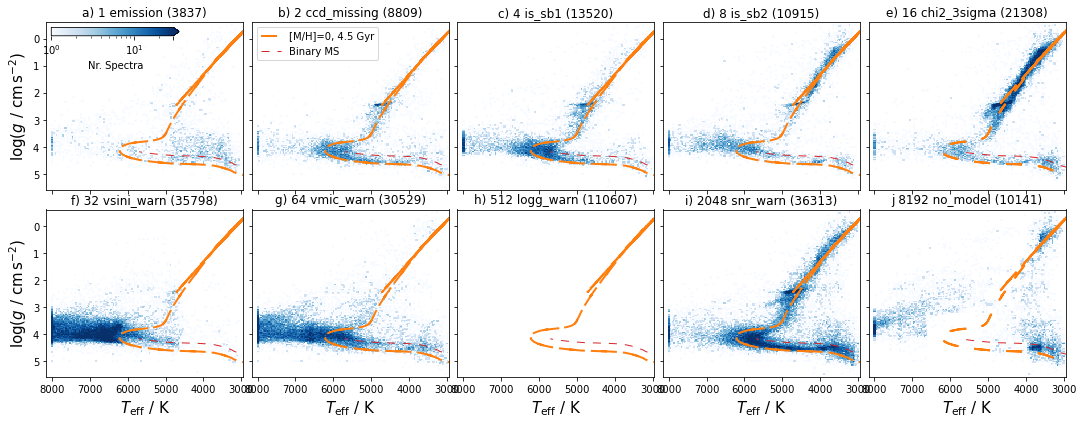

In [1121]:
raised_flags = np.where(flag_list[:,2]!='0')[0]
flags = np.arange(0,16)
raised_flags = flags[raised_flags]

panel = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j']

print(len(raised_flags))

f, gs = plt.subplots(2,5,figsize=(15,6),sharex=True,sharey=True)

parsec_iso1 = (abs(10**(parsec['logAge']-9) - 4.5) < 0.1) & (parsec['m_h'] == 0)

if setup == 'allspec':
    vmax = 100
else:
    vmax = 30

for index,flag in enumerate(raised_flags[1:-1]):
    row = int(np.floor(index/5))
    ax = gs[row,index - row*5]
    
    y_label = 'logg'

    if flag == 0:
        
        flag_raised = data['flag_sp'] == 0
        ax.set_title(panel[index]+' '+str(flag)+' '+list(flag_sp_dictionary.keys())[flag-1]+' ('+str(len(data['flag_sp'][flag_raised]))+')')
                
    else:
        
        flag_raised = (data['flag_sp'] & 2**(flag-1) > 0)
        
        if (2**(flag-1) == flag_sp_dictionary['logg_warn'][0]):
            y_label = 'logg_spec'
        if (2**(flag-1) == flag_sp_dictionary['no_model'][0]):
            y_label = 'logg_spec'
        if setup == 'allstar':
            y_label = 'logg'

        ax.set_title(panel[index]+' '+str(2**(flag-1))+' '+list(flag_sp_dictionary.keys())[flag-1]+' ('+str(len(data['flag_sp'][flag_raised]))+')')
        
    h = ax.hist2d(
        data['teff'][flag_raised],
        data[y_label][flag_raised],
        bins = (np.linspace(2950,8150,150),np.linspace(-0.6,5.6,150)),
        cmin = 1, norm=LogNorm(vmin = 1,vmax = vmax), cmap='Blues',
        zorder = 1
    )

    ax.plot(
        10**parsec['logT'][parsec_iso1],
        parsec['logg'][parsec_iso1],
        zorder = 3,c = 'C1',ls = (0, (8, 8)),lw=2,
        label = '[M/H]=0, 4.5 Gyr'
    )
    ax.plot(
        10**parsec['logT'][parsec_iso1][:30],
        parsec['logg'][parsec_iso1][:30]-0.3,
        zorder = 3,c = 'C3',ls = (0, (8, 8)),lw=1,
        label = 'Binary MS'
    )

    if index == 0:

        axins1 = inset_axes(
            ax,
            width="65%",  # width: 50% of parent_bbox width
            height="5%",  # height: 5%
            loc="upper left",
        )
        cbar = plt.colorbar(h[-1],cax=axins1,orientation="horizontal",ticks = [1,10,vmax],extend='max')
        cbar.set_label('Nr. Spectra')
        
    if index == 1:
        ax.legend(loc='upper left')
        
    if row > 0:
        ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)

gs[0,0].set_ylabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)
gs[1,0].set_ylabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)

ax.set_xlim(8150,2950)
ax.set_ylim(5.6,-0.6)
plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('../validation/figures/flag_sp_overview_'+setup+'.png',dpi=200,bbox_inches='tight')

Flag, Bit, Code
7   ,  64 , vmic_warn


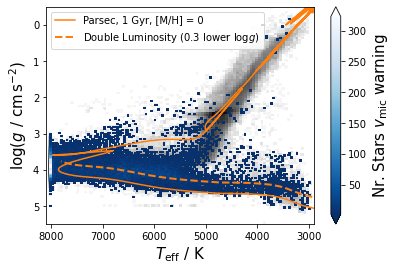

sobject_id,tmass_id,chi2_sp,flag_sp,flag_sp_fit,teff,logg,fe_h,vmic,vsini,ew_h_alpha,mg_fe,r_med,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4
int64,bytes16,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
131216001101006,05242175-5855050,0.7098208,10304,1,3856.2224,4.769166,-1.1197023,0.46914002,12.061349,-0.1651004,0.2527862,153.09885,1.3051765,7.5860133,19.304178,26.898523
131216001101015,05221636-5900200,0.78524035,2112,0,4232.897,4.3414593,-0.42423865,0.25199828,22.231781,0.14703368,0.2773733,433.4099,8.931751,20.4905,33.585712,31.782957
131216001101026,05220701-5904312,1.2988069,76,0,5301.4053,4.298242,-0.5045208,0.2501295,18.999159,-0.31821442,0.19607979,340.55435,54.302757,82.104,112.66131,95.924515
131216001101059,05191171-5903136,1.2916454,108,0,5221.224,4.295575,-0.371202,0.25002378,26.063217,0.2322143,0.2503384,379.90918,72.97231,105.4299,136.9156,121.99325
131216001101070,05202177-5931387,1.0987293,10304,1,3922.3496,4.693674,-0.8269378,0.33933672,9.977809,-0.05508702,-0.09608671,152.38461,6.841658,21.694426,42.68619,46.841705
131216001101076,05190904-5919006,0.74820775,10304,1,3880.7227,4.6790295,-1.2119423,0.34834307,4.5439935,0.0073418794,0.48332456,192.58018,4.5192676,22.499544,41.80927,44.200687
131216001101101,05172590-5943560,0.9728521,10304,1,3883.114,4.600892,-1.1145072,0.26027656,10.950121,0.19713837,0.26828673,154.00348,9.430766,41.6806,68.923294,68.62238
131216001101122,05161634-5916078,1.1437252,72,0,5278.979,4.107058,-0.40727097,0.25,24.494202,-0.15396734,0.32726532,763.703,29.99354,45.108215,61.372715,49.472218
131216001101184,05152453-5855256,1.0163438,2112,0,3355.8716,4.6760635,-0.17893751,0.47185883,20.258322,-0.6511447,0.24549773,173.2956,2.7070763,12.199028,24.66154,29.290188


In [1122]:
flag_bit = 7
flag_raised = (data['flag_sp'] & 2**(flag_bit-1) > 0)
print('Flag, Bit, Code')
print(flag_bit,'  , ',2**(flag_bit-1),',',list(flag_sp_dictionary.keys())[flag_bit-1])

f, ax = plt.subplots()

parsec_selection = (
    (10**(parsec['logAge']-9) > 0.99) &
    (10**(parsec['logAge']-9) < 1.01) &
    (parsec['m_h'] == 0.0)
)

ax.hist2d(
    data['teff'],
    data['logg'],
    bins = (np.linspace(2900,8100,100),np.linspace(-0.5,5.5,100)), cmin=1, norm=LogNorm(), cmap='Greys'
)

h = ax.hist2d(
    data['teff'][flag_raised],
    data['logg'][flag_raised],
    bins = (np.linspace(2900,8100,150),np.linspace(-0.5,5.5,150)), cmin=2,#, vmax = 20,
    cmap = 'Blues_r'
)
cbar = plt.colorbar(h[-1],extend='both')
cbar.set_label(r'Nr. Stars $v_\mathrm{mic}$ warning',fontsize=15)

ax.plot(
    10**parsec['logT'][parsec_selection],
    parsec['logg'][parsec_selection],
    c = 'C1',
    label = 'Parsec, 1 Gyr, [M/H] = 0'
)
ax.plot(
    10**parsec['logT'][parsec_selection][:60],
    parsec['logg'][parsec_selection][:60] - np.log10(2),
    c = 'C1', ls = 'dashed',lw=2,
    label = 'Double Luminosity (0.3 lower $\log g$)'
)
ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
ax.set_ylabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)
ax.legend()
ax.set_xlim(plt.xlim()[::-1])
ax.set_ylim(plt.ylim()[::-1])
plt.show()
plt.close()

data[flag_raised][:10][['sobject_id','tmass_id','chi2_sp','flag_sp','flag_sp_fit','teff','logg','fe_h','vmic','vsini','ew_h_alpha','mg_fe','r_med','snr_px_ccd1','snr_px_ccd2','snr_px_ccd3','snr_px_ccd4']]
# data[flag_raised][['sobject_id','tmass_id','chi2_sp','flag_sp','flag_sp_fit','rv_comp_1','rv_comp_2','sb2_rv_50','sb2_rv_84','teff','logg','fe_h','vmic','vsini','ew_h_alpha','mg_fe','r_med','snr_px_ccd1','snr_px_ccd2','snr_px_ccd3','snr_px_ccd4']]

Flag, Bit, Code
14   ,  8192 , no_model 10141


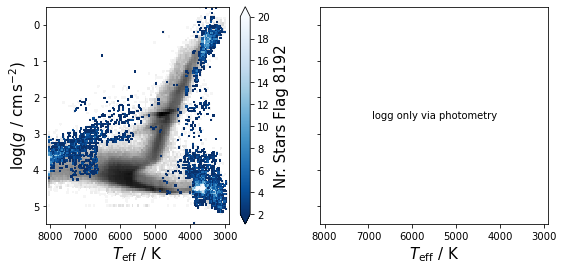

sobject_id,tmass_id,chi2_sp,flag_sp,flag_sp_fit,teff,logg,fe_h,vmic,vsini,ew_h_alpha,mg_fe,r_med,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4
int64,bytes16,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
131216001101006,05242175-5855050,0.7098208,10304,1,3856.2224,4.769166,-1.1197023,0.46914002,12.061349,-0.1651004,0.2527862,153.09885,1.3051765,7.5860133,19.304178,26.898523
131216001101021,05230571-5904150,0.93969595,10240,1,3638.6082,4.454869,-0.54875636,0.7475091,7.9893465,0.363569,-0.054225035,218.69128,8.267657,23.062326,42.091114,44.94617
131216001101027,05204639-5900219,0.6641968,10240,1,3681.8608,4.3980107,-0.7093316,1.5041811,7.8077865,0.3610325,0.09419189,247.72627,3.801695,19.737377,35.894035,35.858963
131216001101070,05202177-5931387,1.0987293,10304,1,3922.3496,4.693674,-0.8269378,0.33933672,9.977809,-0.05508702,-0.09608671,152.38461,6.841658,21.694426,42.68619,46.841705
131216001101075,05195261-5931548,0.77608365,10240,1,3627.2947,4.6592035,-0.8008286,0.77025634,7.409038,0.32533944,0.25214413,116.586914,2.9839888,21.928324,46.419216,53.962112
131216001101076,05190904-5919006,0.74820775,10304,1,3880.7227,4.6790295,-1.2119423,0.34834307,4.5439935,0.0073418794,0.48332456,192.58018,4.5192676,22.499544,41.80927,44.200687
131216001101092,05180895-5925278,0.77037835,10240,1,3649.0574,4.5553765,-0.86391497,1.3698208,7.6223884,0.16269425,0.1628091,164.36624,3.0411556,19.098934,39.721653,44.55309
131216001101101,05172590-5943560,0.9728521,10304,1,3883.114,4.600892,-1.1145072,0.26027656,10.950121,0.19713837,0.26828673,154.00348,9.430766,41.6806,68.923294,68.62238
131216001101110,05164885-5926272,0.80100805,10240,1,3150.94,4.921786,-1.3468647,0.6145639,5.3564405,0.50881875,-0.09626576,91.91552,1.2720469,8.024446,16.879362,17.283592


In [1123]:
flag_bit = 14
flag_raised = (data['flag_sp'] & 2**(flag_bit-1) > 0)
print('Flag, Bit, Code')
print(flag_bit,'  , ',2**(flag_bit-1),',',list(flag_sp_dictionary.keys())[flag_bit-1],len(data['teff'][flag_raised]))

f, gs = plt.subplots(1,2,figsize=(9,4),sharex=True,sharey=True)

ax = gs[0]
ax.hist2d(
    data['teff'],
    data['logg'],
    bins = (np.linspace(2900,8100,100),np.linspace(-0.5,5.5,100)), cmin=1, norm=LogNorm(), cmap='Greys'
)

h = ax.hist2d(
    data['teff'][flag_raised],
    data['logg'][flag_raised],
    bins = (np.linspace(2900,8100,150),np.linspace(-0.5,5.5,150)), cmin=2, vmax = 20,
    cmap = 'Blues_r'
)
cbar = plt.colorbar(h[-1],extend='both',ax=ax)
cbar.set_label(r'Nr. Stars Flag '+str(2**(flag_bit-1)),fontsize=15)

ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
ax.set_ylabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)

ax = gs[1]

if setup == 'allspec':
    ax.hist2d(
        data['teff'],
        data['logg_spec'],
        bins = (np.linspace(2900,8100,100),np.linspace(-0.5,5.5,100)), cmin=1, norm=LogNorm(), cmap='Greys'
    )

    h = ax.hist2d(
        data['teff'][flag_raised],
        data['logg_spec'][flag_raised],
        bins = (np.linspace(2900,8100,150),np.linspace(-0.5,5.5,150)), cmin=2, vmax = 20,
        cmap = 'Blues_r'
    )
    cbar = plt.colorbar(h[-1],extend='both',ax=ax)
    cbar.set_label(r'Nr. Stars Flag '+str(2**(flag_bit-1)),fontsize=15)
else:
    ax.text(0.5,0.5,'logg only via photometry',ha='center',va='center',transform=ax.transAxes)

ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)

ax.set_xlim(plt.xlim()[::-1])
ax.set_ylim(plt.ylim()[::-1])

plt.show()
plt.close()
data[flag_raised][:10][['sobject_id','tmass_id','chi2_sp','flag_sp','flag_sp_fit','teff','logg','fe_h','vmic','vsini','ew_h_alpha','mg_fe','r_med','snr_px_ccd1','snr_px_ccd2','snr_px_ccd3','snr_px_ccd4']]


In [1124]:
# flag_sp_fit_m1 = (data['flag_sp_fit'] & 64 > 0)
# flag_sp_fit_1 = (data['flag_sp_fit'] & 1 > 0)

# ex_sum = 0

# for year in np.arange(13,24,1):
#     year = str(year)
#     for month in np.arange(1,13):
#         if month < 10:
#             month = '0'+str(month)
#         else:
#             month = str(month)
        
#         sobject_id_in_month = (
#             (data['sobject_id'] > int(year) * 10000000000000 + int(month) * 100000000000) & 
#             (data['sobject_id'] < int(year) * 10000000000000 + (int(month)+1) * 100000000000) &
#             (flag_sp_fit_1)
#         )
        
#         if len(data['sobject_id'][sobject_id_in_month]) > 0:
            
#             ex_sum += len(data['sobject_id'][sobject_id_in_month])
        
#             print(year+month,len(data['sobject_id'][sobject_id_in_month]))
            
#             np.savetxt('../spectrum_analysis/batches/'+year+month+'_ex',data['sobject_id'][sobject_id_in_month],fmt='%s')
            
# print(ex_sum)

In [1125]:
schema = [
    ['*Column Name* | *Units* | *Description* | *Data Type* | '],
    [':--------------|:--------------|:------------|:----------|']
]
#star_id |  | 2MASS id   |char[16] | ]
for each_key in data.dtype.names:
    try:
        schema.append([each_key+' | '+str(units[each_key])+' | '+str(description[each_key])+' | '+str(data[each_key].dtype)+' | '])
    except:
        print(each_key)
np.savetxt('schema_galah_dr4_'+setup,np.array(schema),fmt='%s')

date


In [1126]:
a_file = open("../spectrum_post_processing/final_flag_sp_dictionary.pkl", "rb")
flag_sp_dictionary = pickle.load(a_file)
a_file.close()

schema = [
    ['*Bitmask* | *Description* | '],
    [':--------------|:--------------|']
]
schema.append(['0 | No flag rasied | '])
for key in flag_sp_dictionary.keys():
    schema.append([str(flag_sp_dictionary[key][0])+' | '+str(flag_sp_dictionary[key][1])+' | '])
np.savetxt('schema_galah_dr4_flag_sp',np.array(schema),fmt='%s')
schema

[['*Bitmask* | *Description* | '],
 [':--------------|:--------------|'],
 ['0 | No flag rasied | '],
 ['1 | Emission in Halpha/Hbeta detected | '],
 ['2 | Not all 4 CCDs available | '],
 ['4 | Spectroscopic Binary SB1 (RV changes beyond 2sigma) | '],
 ['8 | Spectroscopic Binary SB2 (Double line splitting) | '],
 ['16 | Chi2 unusually low/high by 3 sigma | '],
 ['32 | Broadening (vsini) warning | '],
 ['64 | Microturbulence (vmic) warning | '],
 ['128 | Double line splitting detected (SB2) | '],
 ['256 | Temperature (teff) warning | '],
 ['512 | Gravity (logg) warning | '],
 ['1024 | [Fe/H] (fe_h) warning | '],
 ['2048 | Signal-to-noise indicates spectra not reliable | '],
 ['4096 | Not converged within 4 iterations | '],
 ['8192 | Extrapolating spectrum model | '],
 ['16384 | No spectroscopic analysis results available | ']]

In [1127]:
schema = [
    ['*Bitmask* | *Description* | '],
    [':--------------|:--------------|']
]
schema.append(['0 | No flag rasied | '])
schema.append(['1 | Upper limit | '])
schema.append(['2 | No measurement available | '])
schema.append(['4 | No convergence | '])
schema.append(['8 | Measurement above limit: A(Li) > 4; [X/Fe] > 1.5 for C,N,O,Y,Ba,La,Ce,Nd; [X/Fe] > 1.0 for the rest | '])
schema.append(['16 | Measurement below limit: A(Li) < 0; [X/Fe] < -0.5 for Mg, Si, Ti; [X/Fe] < -1.0 for the rest | '])
schema.append(['32 | Measurement issue of CNO | '])
schema.append(['64 | Wavelength issue warning | '])
np.savetxt('schema_galah_dr4_flag_x_fe',np.array(schema),fmt='%s')
schema

[['*Bitmask* | *Description* | '],
 [':--------------|:--------------|'],
 ['0 | No flag rasied | '],
 ['1 | Upper limit | '],
 ['2 | No measurement available | '],
 ['4 | No convergence | '],
 ['8 | Measurement above limit: A(Li) > 4; [X/Fe] > 1.5 for C,N,O,Y,Ba,La,Ce,Nd; [X/Fe] > 1.0 for the rest | '],
 ['16 | Measurement below limit: A(Li) < 0; [X/Fe] < -0.5 for Mg, Si, Ti; [X/Fe] < -1.0 for the rest | '],
 ['32 | Measurement issue of CNO | '],
 ['64 | Wavelength issue warning | ']]

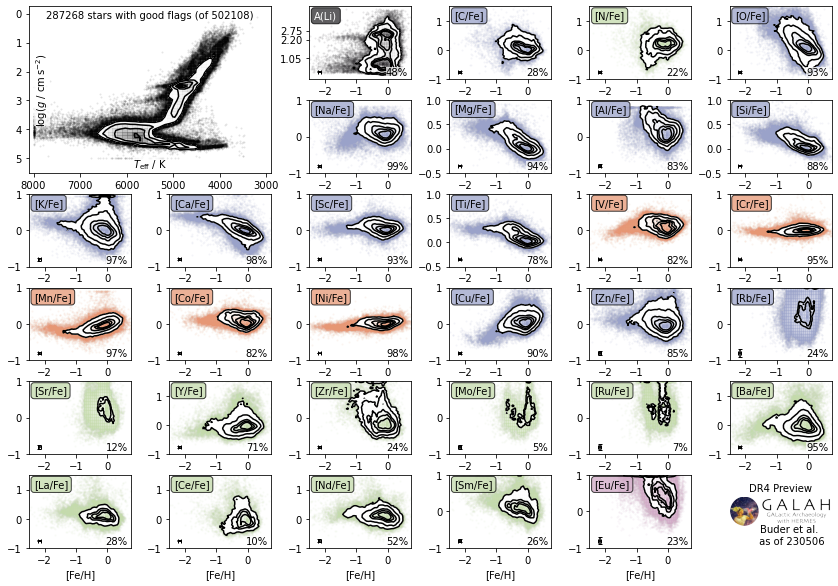

In [1128]:
def plot_galah_dr4_overview_A4(data,name):
    elements = [
        'Li',
        'C',
        'N',
        'O',
        'Na',
        'Mg',
        'Al',
        'Si',
        'K',
        'Ca',
        'Sc',
        'Ti',
        'V',
        'Cr',
        'Mn',
        'Co',
        'Ni',
        'Cu',
        'Zn',
        'Rb',
        'Sr',
        'Y',
        'Zr',
        'Mo',
        'Ru',
        'Ba',
        'La',
        'Ce',
        'Nd',
        'Sm',
        'Eu'
        ]

    fig, axs = plt.subplots(ncols=6, nrows=6, figsize=(11.75,8.25))
    gs = axs[0, 0].get_gridspec()
    for ax in axs[0, :2]:
        ax.remove()
    for ax in axs[1, :2]:
        ax.remove()

    # HRD 

    good_bad_flag_cut = 4
    
    flag_sp_0 = data['flag_sp'] < good_bad_flag_cut
    flag_sp_above0_but_results = (data['flag_sp'] >= good_bad_flag_cut) & (data['flag_sp'] < np.max(data['flag_sp']))
    flag_sp_results = data['flag_sp'] < np.max(data['flag_sp'])
    finite_teff_logg = np.isfinite(data['teff']) & np.isfinite(data['logg'])
    
    teff_limits = [2900,8100]
    logg_limits = [-0.25,5.5]

    axbig = fig.add_subplot(gs[:2, :2])
    corner.hist2d(
        data['teff'][flag_sp_0],
        data['logg'][flag_sp_0],
        bins=(np.linspace(teff_limits[0],teff_limits[1],50),np.linspace(logg_limits[0],logg_limits[1],50)),
        range = (teff_limits,logg_limits),
        ax = axbig
    )
    axbig.set_xlim(teff_limits[1],teff_limits[0])
    axbig.set_ylim(logg_limits[1],logg_limits[0])
    if name == 'allspec':
        axbig.text(0.5,0.93,str(len(data['teff'][flag_sp_0]))+r' spectra with good flags (of '+str(len(data['teff']))+')',transform=axbig.transAxes,ha='center',bbox=dict(boxstyle='square,pad=0',lw=0, facecolor='w', alpha=0.75))
    if name == 'allstar':
        axbig.text(0.5,0.93,str(len(data['teff'][flag_sp_0]))+r' stars with good flags (of '+str(len(data['teff']))+')',transform=axbig.transAxes,ha='center',bbox=dict(boxstyle='square,pad=0',lw=0, facecolor='w', alpha=0.75))
    axbig.text(0.5,0.035,r'$T_\mathrm{eff}~/~\mathrm{K}$',transform=axbig.transAxes,ha='center',bbox=dict(boxstyle='square,pad=0',lw=0, facecolor='w', alpha=0.75))
    axbig.text(0.02,0.5,r'$\log (g~/~\mathrm{cm\,s^{-2}})$',transform=axbig.transAxes,va='center',rotation=90,bbox=dict(boxstyle='square,pad=0',lw=0, facecolor='w', alpha=0.75))

    # read an image
    img = iio.imread("../spectrum_post_processing/figures/logo_desktop.png")

    ax = axs[-1,-1]
    ax.imshow(img)
    ax.axis('off')
    ax.text(0.5,+1.2,'DR4 Preview',transform=ax.transAxes,ha='center')
    ax.text(0.6,-0.6,'Buder et al. \n as of '+today.strftime("%y%m%d"),transform=ax.transAxes,ha='center')

    for ind, label in enumerate(elements):    
        if ind <= 3:
            ax = axs[0,2+ind]
        elif ind <= 7:
            ax = axs[1,2+ind-4]
        elif ind <= 13:
            ax = axs[2,ind-8]
        elif ind <= 19:
            ax = axs[3,ind-14]
        elif ind <= 25:
            ax = axs[4,ind-20]
        elif ind <= 32:
            ax = axs[5,ind-26]
        else:
            raise ValueError('blob')
        if label == 'Li':
            color = '#2B292C'
        elif label in ['C','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','Cu','Zn','Rb']:
            color = '#9AA2C9'
        elif label in ['V','Cr','Mn','Fe','Co','Ni']:
            color = '#E69774'
        elif label in ['N','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm']:
            color = '#C4DAAB'
        elif label in ['Eu']:
            color = '#D0A8C5'

        xbins = np.linspace(-2.5,0.75,50)
        if label == 'Li':
            ybins = np.linspace(-0.25,4.25,50)
        elif label in ['C','N','O','Y','Ba','La','Ce','Nd']:
            ybins = np.linspace(-1,1.5,50)
        elif label in ['Mg','Si','Ti']:
            ybins = np.linspace(-0.5,1,50)
        else:
            ybins = np.linspace(-1,1,50)

        # First panel: Detections for GALAH DR4 [Fe/H] vs. [X/Fe]
        if label == 'Li':
            textcolor = 'w'
            ax.set_yticks([1.05,2.2,2.75])
        else:
            textcolor = 'k'

        flag0 = flag_sp_0 & (data['flag_'+label.lower()+'_fe'] == 0) #& (data['fe_h'] > -1)

        if label == 'Li':
            ax.text(0.05,0.83,'A('+label+')',ha='left',color=textcolor, transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor=color, alpha=0.75))
        else:
            ax.text(0.05,0.83,'['+label+'/Fe]',ha='left',color=textcolor, transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor=color, alpha=0.75))
        ax.text(0.97,0.05,"{:.0f}".format(100*len(data['e_fe_h'][flag0])/len(data['teff'][flag_sp_0]))+'%',ha='right', transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='square,pad=0',lw=0,facecolor='w', alpha=0.75))

        levels = (0.97,0.9,0.68,0.5,0.3)
        if label in ['La','Ce','Sm','Eu']:
            levels = (0.9,0.68,0.5,0.3)
        elif label in ['Rb','Sr','Mo','Ru']:
            levels = (0.5,0.3)
            
        ydata = data[label.lower()+'_fe'][flag0]
        if label == 'Li':
            ydata = data[label.lower()+'_fe'][flag0] + data['fe_h'][flag0] + 1.05
            
        #if (len(data['fe_h'][flag0]) > 20) & (label != 'Rb'):
        corner.hist2d(
            data['fe_h'][flag0],
            ydata,
            bins = (xbins,ybins),
            levels = levels,
            contour_kwargs=dict(colors=['k']),
            color=color,
            range=[(xbins[0],xbins[-1]),(ybins[0],ybins[-1])],
            ax = ax
        )
        ax.set_xlim(xbins[0],xbins[-1])
        ax.set_ylim(ybins[0],ybins[-1])
        ax.errorbar(
            0.9*xbins[0]+0.1*xbins[-1],
            0.9*ybins[0]+0.1*ybins[-1],
            xerr=np.ma.median(data['e_fe_h'][flag0]),
            yerr=np.ma.median(data['e_'+label.lower()+'_fe'][flag0]),
            capsize=2,color='k'
        )
        if ind >= 26:
            ax.set_xlabel('[Fe/H]')
    #     else:
        ax.set_xticks([-2,-1,0])
    plt.tight_layout(h_pad=0,w_pad=0)
    plt.savefig('../spectrum_post_processing/figures/galah_dr4_overview_'+name+'.png',dpi=150,bbox_inches='tight')
    plt.show()
    plt.close()

plot_galah_dr4_overview_A4(data=data,name=setup)